In [64]:
from typing import List

import numpy as np
import csv
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, BASE_COLORS
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from itertools import product
from random import shuffle

colors = list(BASE_COLORS.keys()) + list(TABLEAU_COLORS.keys())
shuffle(colors)
print(colors)

['tab:red', 'tab:orange', 'g', 'tab:pink', 'c', 'tab:cyan', 'w', 'tab:green', 'r', 'tab:blue', 'm', 'tab:olive', 'tab:gray', 'b', 'tab:brown', 'tab:purple', 'k', 'y']


In [12]:
noise_ws = [0.0, 0.3, 0.75, 1.0]
reward_ws = [0.0, 0.3, 0.6, 1.0]
seeds = [12, 42, 69, 10420]
# seeds = [128, 4242, 1234, 48]
# seeds = [12, 42, 69, 10420, 128, 4242, 1234, 48]
# postfix = '_arch'
postfix = ''
# experiment = 'poster_mal_agent_reward'
# experiment = 'report_mal_noise'
experiment = 'report_mal_noise_reward'

In [49]:
def interpolate(x, y, at):
    return interp1d(x, y, kind="linear", fill_value=(np.min(y), np.max(y)), bounds_error=False)(at)

def plot(all_evals: List, label: str, smooth_factor=2, color="b", max_samples=None, eval_rate=None):
    intervals = np.arange(0, max_samples, eval_rate)
    all_evals = np.stack([interpolate(np.array(evals)[:,0],np.array(evals)[:,1],intervals) for evals in all_evals])
    mean_reward = all_evals.mean(axis=0)
    sem_reward = sem(all_evals, axis=0)
    ci_95 = 1.96 * sem_reward

    mean_reward_smooth = gaussian_filter1d(mean_reward, smooth_factor)
    ci_95_smooth = gaussian_filter1d(ci_95, smooth_factor)

    plt.plot(intervals, mean_reward_smooth, label=label, color=color)
    # plt.fill_between(intervals, mean_reward_smooth - ci_95_smooth, mean_reward_smooth + ci_95_smooth, color=color, alpha=0.2)

def load_evals(path):
    path = Path(path)
    assert path.exists()
    with open(path, newline='') as file:
        rd = csv.reader(file)
        return np.array(list(rd), dtype='float')

[PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.0_reward_0.0_seed_12'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.0_reward_0.0_seed_42'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.0_reward_0.0_seed_69'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.0_reward_0.0_seed_10420'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.0_reward_0.3_seed_12'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.0_reward_0.3_seed_42'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


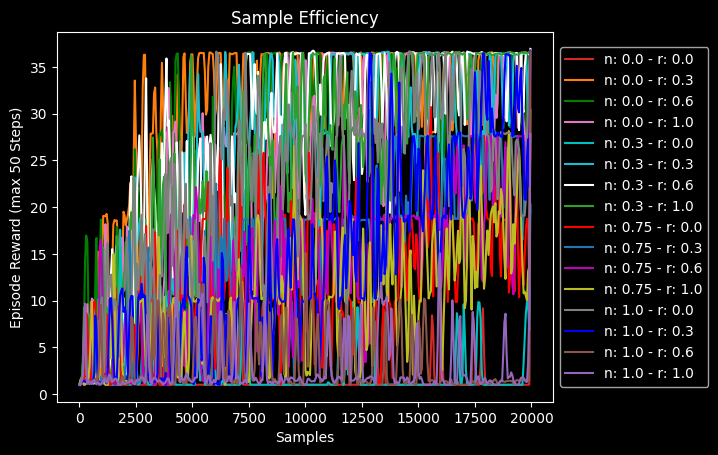

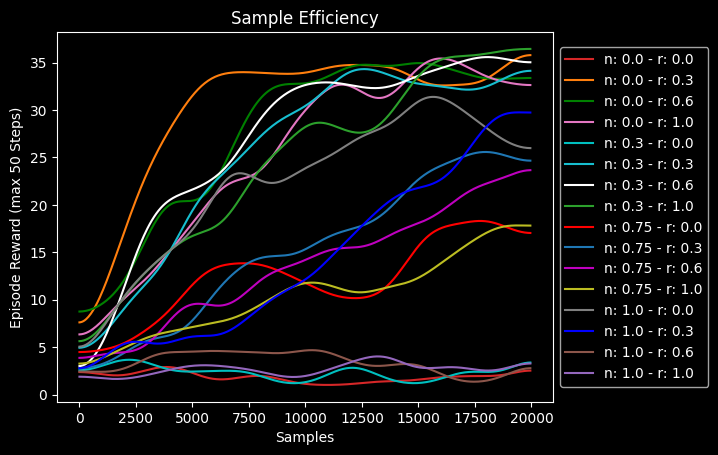

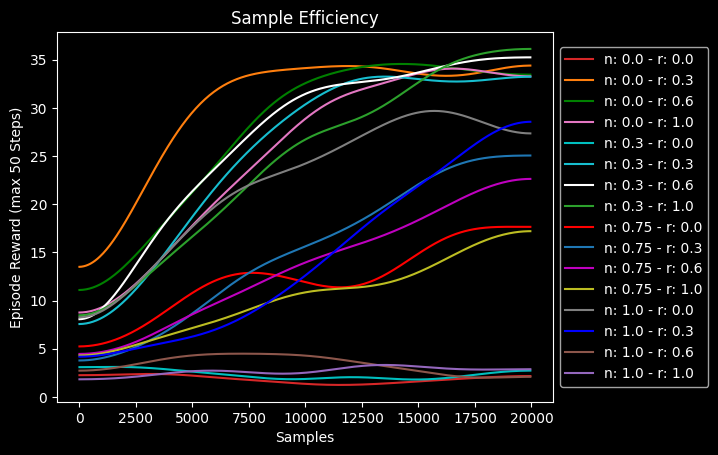

In [68]:
path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / experiment / "sample_efficiency"
stems = list(product(noise_ws, reward_ws))
paths = [path / f"noise_{noise}_reward_{reward}_seed_{seed}{postfix}" for (noise, reward), seed in product(stems, seeds)]
print(paths)
evals = np.stack(load_evals(p) for p in paths)
max_samples = np.max(evals[:, :, 0])
pts_cnt = evals.shape[1]
evals = evals.reshape(-1, len(seeds), pts_cnt, 2)

plt.style.use('dark_background')
for smooth_factor in [0.1, 20, 40]:
    plt.figure()
    # smooth_factor = 20.0
    for e, (noise, reward), c in zip(evals, stems, colors):
        plot(e, f"n: {noise} - r: {reward}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# This part is just for creating data

In [13]:
%load_ext autoreload
%autoreload 2

from stackelberg_mbrl.experiments.experiment_config import ExperimentConfig, EnvConfig, PolicyConfig, WorldModelConfig, LoadPolicy, LeaderEnvConfig, SampleEfficiency
from stackelberg_mbrl.train_mal import train_contextualized_MAL
from itertools import product

for reward_w, noise_w, seed in product(reward_ws, noise_ws, seeds):
    config = ExperimentConfig(
        experiment_name=experiment,
        env_config=EnvConfig(
            env_true_id="simple_mdp_2",
            env_eval_id="simple_mdp_2",
            max_episode_steps=50
        ),
        policy_config=LoadPolicy(
            # just use the same one...
            path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
        ),
        # policy_config=PolicyConfig(
        #     pretrain_iterations=1,
        #     samples_per_training_iteration=1_000_000,
        #     model_save_name="policy_simple_mdp_2",
        # ),
        leader_env_config=LeaderEnvConfig(
            env_noise_weight=lambda step: noise_w,
            env_reward_weight=reward_w,
        ),
        sample_efficiency=SampleEfficiency(
            sample_eval_rate=100,
            n_eval_episodes=30,
            max_samples=20_000,
            log_save_name=f"noise_{noise_w}_reward_{reward_w}_seed_{seed}{postfix}"
        ),
        world_model_config=WorldModelConfig(
            total_training_steps=250_000,
            # total_training_steps=1_000,
            # model_save_name="simple_mdp_2",
        ),
        seed=seed
    )

    train_contextualized_MAL(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_states` for environment variables or `env.get_wrapper_attr('num_states')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.draw_mdp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this v

Loading policy model from file.


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


Output()

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: 
DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the 
environment initialisation to be passed additional information.
  logger.deprecation(

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Training world model


Model reward: (-0.35702086620149204, 0.5511245900165865)
Avg Policy Reward on learned model:   0.725 ± 0.553
Avg Policy Reward on real env:   0.975 ± 0.040
Loading policy model from file.


Output()

Training world model


Model reward: (-0.0999998807932516, 0.2999996423712843)
Avg Policy Reward on learned model:   1.000 ± 0.000
Avg Policy Reward on real env:   0.985 ± 0.032
Loading policy model from file.


Output()

Training world model


Model reward: (-0.34999958276804755, 0.5499993443485505)
Avg Policy Reward on learned model:   0.835 ± 0.495
Avg Policy Reward on real env:   0.970 ± 0.033
Loading policy model from file.


Output()

Training world model


Model reward: (-0.09994429993848257, 0.2998322028311748)
Avg Policy Reward on learned model:   1.000 ± 0.000
Avg Policy Reward on real env:   0.985 ± 0.023
Loading policy model from file.


Output()

Training world model


Model reward: (-0.12829010379500688, 0.38174611763097344)
Avg Policy Reward on learned model:   0.995 ± 0.015
Avg Policy Reward on real env:   1.000 ± 0.000
Loading policy model from file.


Output()

Training world model


Model reward: (-0.20067373450510786, 0.42694173521377377)
Avg Policy Reward on learned model:   2.050 ± 3.372
Avg Policy Reward on real env:   0.995 ± 0.015
Loading policy model from file.


Output()

Training world model


Model reward: (-0.2325093166946317, 0.470896383871306)
Avg Policy Reward on learned model:   1.000 ± 0.000
Avg Policy Reward on real env:   0.985 ± 0.023
Loading policy model from file.


Output()

Training world model


Model reward: (-0.18914004676043988, 0.37404261771589514)
Avg Policy Reward on learned model:   1.000 ± 0.000
Avg Policy Reward on real env:   0.990 ± 0.020
Loading policy model from file.


Output()

Training world model


Model reward: (-0.04490556144155562, 0.05743547400603257)
Avg Policy Reward on learned model:   21.900 ± 14.215
Avg Policy Reward on real env:   36.610 ± 0.480
Loading policy model from file.


Output()

Training world model


Model reward: (-0.2480384577793302, 0.5082315469566018)
Avg Policy Reward on learned model:   1.000 ± 0.000
Avg Policy Reward on real env:   0.995 ± 0.015
Loading policy model from file.


Output()

Training world model


Model reward: (-0.3068172520957887, 0.37186916109411006)
Avg Policy Reward on learned model:   1.765 ± 1.380
Avg Policy Reward on real env:   36.690 ± 0.804
Loading policy model from file.


Output()

Training world model


Model reward: (-0.10843189302831888, 0.1758599842171776)
Avg Policy Reward on learned model:   1.915 ± 3.089
Avg Policy Reward on real env:   0.995 ± 0.015
Loading policy model from file.


Output()

Training world model


Model reward: (-0.09257998764514923, 0.010502847993252564)
Avg Policy Reward on learned model:   4.035 ± 5.856
Avg Policy Reward on real env:   35.010 ± 2.790
Loading policy model from file.


Output()

Training world model


Model reward: (-0.02539101814618334, 0.05487080566686374)
Avg Policy Reward on learned model:   29.135 ± 13.943
Avg Policy Reward on real env:   36.370 ± 1.406
Loading policy model from file.


Output()

Training world model


Model reward: (-1.1410798609256745, 0.22314932444970625)
Avg Policy Reward on learned model:   5.320 ± 5.359
Avg Policy Reward on real env:   3.225 ± 2.011
Loading policy model from file.


Output()

Training world model


Model reward: (-0.198045461345464, 0.3862705385219225)
Avg Policy Reward on learned model:   1.280 ± 1.685
Avg Policy Reward on real env:   0.970 ± 0.046
Loading policy model from file.


Output()

Training world model


Model reward: (10.51927815633826, 0.9997107172183769)
Avg Policy Reward on learned model:   21.720 ± 9.796
Avg Policy Reward on real env:   36.450 ± 1.239
Loading policy model from file.


Output()

Training world model


Model reward: (10.854090921208263, 0.4743979696958945)
Avg Policy Reward on learned model:   26.985 ± 10.820
Avg Policy Reward on real env:   36.770 ± 0.531
Loading policy model from file.


Output()

Training world model


Model reward: (10.674842986650765, 0.718446217468197)
Avg Policy Reward on learned model:   12.635 ± 7.803
Avg Policy Reward on real env:   36.770 ± 0.960
Loading policy model from file.


Output()

Training world model


Model reward: (11.006078759301454, 0.23990244144464815)
Avg Policy Reward on learned model:   10.210 ± 6.910
Avg Policy Reward on real env:   35.730 ± 2.412
Loading policy model from file.


Output()

Training world model


Model reward: (10.83058981699869, 0.2894048088416466)
Avg Policy Reward on learned model:   18.205 ± 11.600
Avg Policy Reward on real env:   36.850 ± 0.400
Loading policy model from file.


Output()

Training world model


Model reward: (10.766985449101776, 0.43230763453515825)
Avg Policy Reward on learned model:   25.295 ± 11.014
Avg Policy Reward on real env:   35.570 ± 1.974
Loading policy model from file.


Output()

Training world model


Model reward: (10.704178261198104, 0.39180253145278765)
Avg Policy Reward on learned model:   6.595 ± 8.135
Avg Policy Reward on real env:   36.290 ± 1.061
Loading policy model from file.


Output()

Training world model


Model reward: (10.873157249670475, 0.3447721709353993)
Avg Policy Reward on learned model:   7.125 ± 5.255
Avg Policy Reward on real env:   36.690 ± 1.189
Loading policy model from file.


Output()

Training world model


Model reward: (10.901782391406595, 0.285554749680091)
Avg Policy Reward on learned model:   10.950 ± 9.809
Avg Policy Reward on real env:   36.210 ± 1.928
Loading policy model from file.


Output()

Training world model


Model reward: (10.800060390401631, 0.3637459664617293)
Avg Policy Reward on learned model:   21.890 ± 5.493
Avg Policy Reward on real env:   36.370 ± 1.040
Loading policy model from file.


Output()

Training world model


Model reward: (10.870325567014515, 0.36379323849591494)
Avg Policy Reward on learned model:   3.625 ± 3.811
Avg Policy Reward on real env:   36.130 ± 1.723
Loading policy model from file.


Output()

Training world model


Model reward: (0.29029688239097595, 0.0)
Avg Policy Reward on learned model:   0.865 ± 0.489
Avg Policy Reward on real env:   0.985 ± 0.023
Loading policy model from file.


Output()

Training world model


Model reward: (11.042119203973561, 0.17596489810326715)
Avg Policy Reward on learned model:   11.890 ± 8.601
Avg Policy Reward on real env:   35.650 ± 1.131
Loading policy model from file.


Output()

Training world model


Model reward: (10.959704764839262, 0.20554105615508367)
Avg Policy Reward on learned model:   1.825 ± 3.705
Avg Policy Reward on real env:   36.530 ± 0.755
Loading policy model from file.


Output()

Training world model


Model reward: (0.2986632287502289, 0.0)
Avg Policy Reward on learned model:   0.960 ± 0.342
Avg Policy Reward on real env:   0.990 ± 0.020
Loading policy model from file.


Output()

Training world model


Model reward: (5.0889024722389875, 4.9356909682048205)
Avg Policy Reward on learned model:   2.155 ± 2.313
Avg Policy Reward on real env:   0.980 ± 0.024
Loading policy model from file.


Output()

Training world model


Model reward: (21.76561211850494, 0.6003432910892056)
Avg Policy Reward on learned model:   4.795 ± 4.727
Avg Policy Reward on real env:   35.970 ± 1.250
Loading policy model from file.


Output()

Training world model


Model reward: (21.65426238439977, 0.770575276575831)
Avg Policy Reward on learned model:   11.205 ± 9.741
Avg Policy Reward on real env:   36.530 ± 1.211
Loading policy model from file.


Output()

Training world model


Model reward: (21.742634465359153, 0.7057746611478666)
Avg Policy Reward on learned model:   22.300 ± 2.182
Avg Policy Reward on real env:   36.050 ± 1.570
Loading policy model from file.


Output()

Training world model


Model reward: (15.032797295600176, 5.909462476492721)
Avg Policy Reward on learned model:   1.735 ± 1.043
Avg Policy Reward on real env:   36.450 ± 0.947
Loading policy model from file.


Output()

Training world model


Model reward: (20.960892852395773, 1.6193364335105012)
Avg Policy Reward on learned model:   21.530 ± 12.421
Avg Policy Reward on real env:   36.770 ± 0.531
Loading policy model from file.


Output()

Training world model


Model reward: (21.48840829450637, 1.2018288135299302)
Avg Policy Reward on learned model:   19.575 ± 7.343
Avg Policy Reward on real env:   36.530 ± 1.040
Loading policy model from file.


Output()

Training world model


Model reward: (21.706620230711998, 0.7006397173346087)
Avg Policy Reward on learned model:   16.590 ± 12.971
Avg Policy Reward on real env:   36.770 ± 0.733
Loading policy model from file.


Output()

Training world model


Model reward: (22.184456128440797, 0.22531778634097346)
Avg Policy Reward on learned model:   8.930 ± 9.291
Avg Policy Reward on real env:   36.850 ± 0.645
Loading policy model from file.


Output()

Training world model


Model reward: (12.620594202913344, 6.801723207630427)
Avg Policy Reward on learned model:   17.120 ± 13.685
Avg Policy Reward on real env:   36.610 ± 0.999
Loading policy model from file.


Output()

Training world model


Model reward: (21.707243635691704, 0.9111277934534583)
Avg Policy Reward on learned model:   19.560 ± 13.047
Avg Policy Reward on real env:   36.450 ± 0.947
Loading policy model from file.


Output()

Training world model


Model reward: (21.825415705516935, 0.5402803182698994)
Avg Policy Reward on learned model:   3.585 ± 3.313
Avg Policy Reward on real env:   37.010 ± 0.512
Loading policy model from file.


Output()

Training world model


Model reward: (0.5996899604797363, 0.0)
Avg Policy Reward on learned model:   0.995 ± 0.015
Avg Policy Reward on real env:   0.990 ± 0.020
Loading policy model from file.


Output()

Training world model


Model reward: (1.4447045160457492, 1.1270882959021025)
Avg Policy Reward on learned model:   1.325 ± 0.492
Avg Policy Reward on real env:   3.085 ± 0.984
Loading policy model from file.


Output()

Training world model


Model reward: (0.5522648813202977, 0.09516688529402019)
Avg Policy Reward on learned model:   0.890 ± 0.297
Avg Policy Reward on real env:   0.980 ± 0.033
Loading policy model from file.


Output()

Training world model


Model reward: (0.4768845891579986, 0.18634941859922347)
Avg Policy Reward on learned model:   0.995 ± 0.015
Avg Policy Reward on real env:   0.970 ± 0.040
Loading policy model from file.


Output()

Training world model


Model reward: (0.5390841264277697, 0.14018228687345982)
Avg Policy Reward on learned model:   1.190 ± 0.547
Avg Policy Reward on real env:   0.980 ± 0.033
Loading policy model from file.


Output()

Training world model


Model reward: (36.28999999910593, 0.9329523040441277)
Avg Policy Reward on learned model:   13.395 ± 12.763
Avg Policy Reward on real env:   36.290 ± 0.999
Loading policy model from file.


Output()

Training world model


Model reward: (36.52999999932945, 0.9765244501681555)
Avg Policy Reward on learned model:   5.755 ± 5.121
Avg Policy Reward on real env:   36.290 ± 0.784
Loading policy model from file.


Output()

Training world model


Model reward: (36.28999999910593, 0.6974238316160343)
Avg Policy Reward on learned model:   17.945 ± 12.785
Avg Policy Reward on real env:   36.770 ± 0.816
Loading policy model from file.


Output()

Training world model


Model reward: (36.769999999552965, 0.8158431229346587)
Avg Policy Reward on learned model:   4.830 ± 4.857
Avg Policy Reward on real env:   36.690 ± 0.625
Loading policy model from file.


Output()

Training world model


Model reward: (36.92999999970198, 0.5306599669510795)
Avg Policy Reward on learned model:   13.170 ± 6.964
Avg Policy Reward on real env:   35.890 ± 0.880
Loading policy model from file.


Output()

Training world model


Model reward: (36.04999999888241, 2.1241468895545466)
Avg Policy Reward on learned model:   21.530 ± 11.096
Avg Policy Reward on real env:   36.690 ± 0.720
Loading policy model from file.


Output()

Training world model


Model reward: (36.04999999888241, 0.6449806204645689)
Avg Policy Reward on learned model:   13.025 ± 12.415
Avg Policy Reward on real env:   36.530 ± 0.755
Loading policy model from file.


Output()

Training world model


Model reward: (36.68999999947846, 0.5122499394716978)
Avg Policy Reward on learned model:   10.720 ± 9.024
Avg Policy Reward on real env:   36.610 ± 0.599
Loading policy model from file.


Output()

Training world model


Model reward: (7.829999998211861, 8.001631082793319)
Avg Policy Reward on learned model:   2.000 ± 0.792
Avg Policy Reward on real env:   2.555 ± 1.090
Loading policy model from file.


Output()

Training world model


Model reward: (36.42499999925494, 0.8795595496784238)
Avg Policy Reward on learned model:   3.925 ± 4.595
Avg Policy Reward on real env:   36.850 ± 0.645
Loading policy model from file.


Output()

Training world model


Model reward: (20.154999999329448, 12.979511739630924)
Avg Policy Reward on learned model:   2.320 ± 3.859
Avg Policy Reward on real env:   35.970 ± 1.300
Loading policy model from file.


Output()

Training world model


Model reward: (1.8099999990314246, 0.7515982964173454)
Avg Policy Reward on learned model:   1.570 ± 0.651
Avg Policy Reward on real env:   2.080 ± 0.699
Loading policy model from file.


Output()

Training world model


Model reward: (1.61999999769032, 0.7018546837042902)
Avg Policy Reward on learned model:   5.490 ± 5.548
Avg Policy Reward on real env:   2.525 ± 1.193
Loading policy model from file.


Output()

Training world model


Model reward: (1.0349999997764825, 0.13973188599418587)
Avg Policy Reward on learned model:   0.985 ± 0.487
Avg Policy Reward on real env:   0.980 ± 0.033
Loading policy model from file.


Output()

Training world model


Model reward: (0.9799999997019768, 0.033166248397769604)
Avg Policy Reward on learned model:   0.945 ± 0.047
Avg Policy Reward on real env:   0.975 ± 0.051
Loading policy model from file.


Output()

Training world model


Model reward: (1.419999999552965, 0.8189017034956511)
Avg Policy Reward on learned model:   1.275 ± 1.401
Avg Policy Reward on real env:   2.215 ± 0.719
